In [1]:
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
import pickle as pkl
sys.path.append('..')

import data
import style
import config
from config import *
import util
import glob
import json, jsonlines

df = data.load_all_labs()
df = df.set_index('fname_id')

# get fnames
fname_nps = [f for f in sorted(os.listdir(DIR_GEN)) if 'npy' in f] # these start at 00001
fname_ids = np.array([f[:-4] for f in fname_nps])
idxs_calculated = np.array([int(x) - 1 for x in fname_ids]) # this starts at 0

# trim df to only have the relevant ids
df = df.loc[fname_ids]

loading cached labels


# select celebrities

In [2]:
# only consider ids with more than 2 ims
d = df[df['count_with_this_id'] > 2]

# sort by how many ids each image has
d = d.sort_values('count_with_this_id', ascending=False)

# get ids for subgroups
subgroups = {}
for gender in [0, 1]:
    for race in ['Black', 'White']:
        dd = d[d['gender'] == gender]
        dd = dd[dd['race_pred'] == race]
        print(gender, race, '|', dd.id.unique().size, 'ids\t', dd.shape[0], 'photos')        
        subgroups[(gender, race)] = dd.id.unique()

def pair_plot(im0, im1):
    R, C = 1, 2
    plt.subplot(R, C, 1)
    plt.title('Real photo')
    util.imshow(im0)
    plt.subplot(R, C, 2)
    plt.title('Test photo')
    util.imshow(im1)
    plt.tight_layout()
    
def slight_random_crop(im):
    x = np.random.randint(20, 35)
    return im[x: -x, x: -x]

0 Black | 91 ids	 468 photos
0 White | 1468 ids	 8536 photos
1 Black | 157 ids	 570 photos
1 White | 842 ids	 3608 photos


In [ ]:
np.random.seed(13)
N_IMS = 30
EXPERIMENT_DIR = oj(DIR_PROCESSED, 'projections_annotation_double', 'ims')
os.makedirs(EXPERIMENT_DIR, exist_ok=True)
for gender, race in tqdm(subgroups.keys()):
    # print(gender, race)
    ids = subgroups[(gender, race)]
    for i in tqdm(ids[:N_IMS]):
        ims = d[d.id == i].iloc[:2]
        im0 = mpimg.imread(oj(DIR_IMS, ims.fname_final.values[0]))
        im1 = mpimg.imread(oj(DIR_IMS, ims.fname_final.values[1]))
        im1_rec = mpimg.imread(oj(DIR_GEN, ims.fname_final.values[1][:-4] + '.png'))
        pair_plot(im0, im1)
        plt.savefig(oj(EXPERIMENT_DIR, f'{gender}_{race}_{i}_real.png'), dpi=300)
        pair_plot(im0, im1_rec)
        plt.savefig(oj(EXPERIMENT_DIR, f'{gender}_{race}_{i}_fake.png'), dpi=300)
        pair_plot(im0, slight_random_crop(im0))
        plt.savefig(oj(EXPERIMENT_DIR, f'{gender}_{race}_{i}_dup.png'), dpi=300)        

In [ ]:
len(os.listdir(oj(DIR_PROCESSED, 'projections_annotation_double', 'ims')))

# analyze results

In [2]:
ANNOTATIONS_DIR = DIR_PROJ_ANNOTATIONS
LABELS_FILE = '/annotation-tool/data.json'
OUT_MANIFEST_FILE = '/manifests/output/output.manifest'
WORKERS_RESPONSE = '/annotations/worker-response'
OUTPUT_PDF_DIR = './figures' # location of output pdfs


sys.path.append(oj(DIR_REPO, 'disentangling_latent_space'))
from annotation_dset import annotationDatabase

In [3]:
# Get list of experiments in annotation dir. Alternatively, specify ones you care about.
annotations_dict = {}
annotations_names_dict = {}
experiments = [os.path.split(f)[1] for f in glob.glob(os.path.join(ANNOTATIONS_DIR, '*'))]
print('experiments', experiments)
experiments = ['.'] #'perona-causal-faces-uncanny-000']

# If output directory doesn't exist, make it
if not os.path.exists(OUTPUT_PDF_DIR):
    os.makedirs(OUTPUT_PDF_DIR)

# Do analysis figures for each experiment
for EXPERIMENT_LABEL in experiments:
    ANNOTATIONS_PATH = f'{ANNOTATIONS_DIR}/{EXPERIMENT_LABEL}{WORKERS_RESPONSE}'
    OUT_MANIFEST_PATH = f'{ANNOTATIONS_DIR}/{EXPERIMENT_LABEL}{OUT_MANIFEST_FILE}'
    LABELS_PATH = f'{ANNOTATIONS_DIR}/{EXPERIMENT_LABEL}{LABELS_FILE}'
    OUT_PDF_FILE_NAME = os.path.join(OUTPUT_PDF_DIR, EXPERIMENT_LABEL + '.pdf')

    #Read labels using annotation-tool/data.json and assign integers to labels 
    with open(LABELS_PATH, 'r') as labels_file:
        labels_data = json.load(labels_file)['labels']
        LABELS = [l['label'] for l in labels_data]
    # labelScores = {l:i for (i, l) in enumerate(LABELS)} # generate numerical scores for the labels - useful in regression
    labelScores = {l:l for (i, l) in enumerate(LABELS)} # generate numerical scores for the labels - useful in regression

    # Get ordered list of image names from output manifest
    image_names = []
    with jsonlines.open(OUT_MANIFEST_PATH) as reader:
        for obj in reader:
            _, name = os.path.split(obj['source-ref']) #remove leading path
            image_names.append(name)

    # Make map from annotation index to image index
    idx_map = []
    with jsonlines.open(OUT_MANIFEST_PATH) as reader:
        for obj in reader:
            _, name = os.path.split(obj['source-ref']) #remove leading path
#             print(name)
            idx = name.split('.')[0]
            idx_map.append(idx)

    # Make annotation file name list in proper order (keep same order)
    annotation_file_names = []
    for i in range(len(idx_map)):
        annotation_file_names += glob.glob(ANNOTATIONS_PATH + '/*/%d/*.json'% i)


        
    # put together the database of the annotator IDs and their work
    annotations = annotationDatabase(annotation_file_names, labelScores, label_type='crowd-image-classifier-multi-select')
    annotations.startPDFReport(OUT_PDF_FILE_NAME, EXPERIMENT_LABEL)
    fig = annotations.displayAnnotatorsWork()
#     annotations.displaySequenceAnnotations(image_names, LABELS, SEQUENCE_LENGTH, IMAGE_PATH)
    annotations.endPDFReport()
    
    print(LABELS, np.array(annotations.imageScores).shape)
    annotations_dict[EXPERIMENT_LABEL] = np.array(annotations.imageScores)
    annotations_names_dict[EXPERIMENT_LABEL] = LABELS

mat_list = annotations_dict['.']
print('saved!')

experiments ['intermediate', 'annotation-tool', 'annotations', 'manifests']
Found 360 images and 76 annotators.
['Same person', 'Not same person', '-------------', 'Well', 'Moderately well', 'Not at all'] (360, 3)
saved!


## num annotators plot

In [ ]:
n_annotations = sorted(annotations.annotations, reverse=True)
plt.figure(dpi=300)
plt.grid()
plt.plot(range(1, 1 + annotations.N_ANNOTATORS), n_annotations)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of annotators')
plt.ylabel('Number of annotations')
plt.title('Work of individual annotators')
plt.show()

In [87]:
def same_or_not(l):
    if 'Same person' in l:
        return True
    elif 'Not same person' in l:
        return False
    else:
        return np.nan
sames = np.vectorize(same_or_not)(mat_list)
means = np.mean(sames * 1, axis=1)

In [88]:
fnames = sorted([f for f in os.listdir(oj(DIR_PROCESSED, 'projection_annotations', 'ims'))
        if 'png' in f])
labs = {
    'race=black': list(map(lambda x: 'Black' in x, fnames)),
    'gender': list(map(lambda x: '0_' in x, fnames)),
    'dup': list(map(lambda x: 'dup' in x, fnames)),
    'fake': list(map(lambda x: 'fake' in x, fnames)),
    'real': list(map(lambda x: 'real' in x, fnames)),
}
labs = pd.DataFrame.from_dict(labs)
LABS = ['dup', 'fake', 'real']

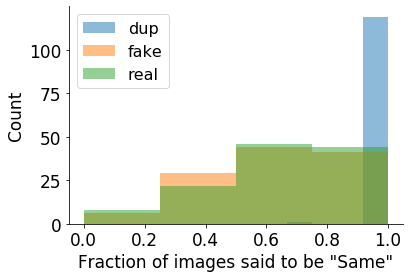

In [89]:
BINS = 4
for lab in LABS:
    plt.hist(means[labs[lab]], BINS, alpha=0.5, label=lab)
plt.ylabel('Count')
plt.xlabel('Fraction of images said to be "Same"')
plt.legend()
plt.show()

Text(0.5, 0, 'Fraction of images labelled as "Same"')

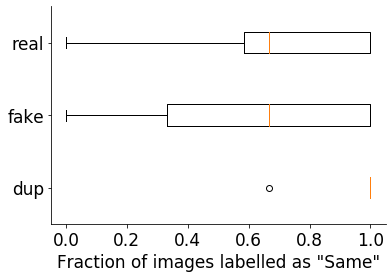

In [90]:
BINS = 4
lists = [means[labs[lab]] for lab in LABS]
plt.boxplot(lists, vert=False)
plt.yticks(np.arange(1, len(LABS) + 1), LABS)
plt.xlabel('Fraction of images labelled as "Same"')

In [103]:
for lab in LABS:
    prob = np.mean(means[labs[lab]])
    n = means[labs[lab]].size * mat_list.shape[1]
    print(f'{lab}, {n}, {100 * prob:0.1f}, 95% CI, {100 * 1.96 * prob * (1-prob) / np.sqrt(n):.2f}')

dup, 360, 99.7, 95% CI, 0.03
fake, 360, 66.7, 95% CI, 2.30
real, 360, 68.3, 95% CI, 2.24
